# **Expt no.1: Build a Recommendation Engine with Item-Based Collaborative Filtering**

Step 0: Item-Based Collaborative Filtering Recommendation Algorithm
Firstly, let’s understand how item-based collaborative filtering works.

Item-based collaborative filtering makes recommendations based on user-product interactions in the past. The assumption behind the algorithm is that users like similar products and dislike similar products, so they give similar ratings to similar products.

Item-based collaborative filtering algorithm usually has the following steps:

Calculate item similarity scores based on all the user ratings.
Identify the top n items that are most similar to the item of interest.
Calculate the weighted average score for the most similar items by the user.
Rank items based on the score and pick top n items to recommend.
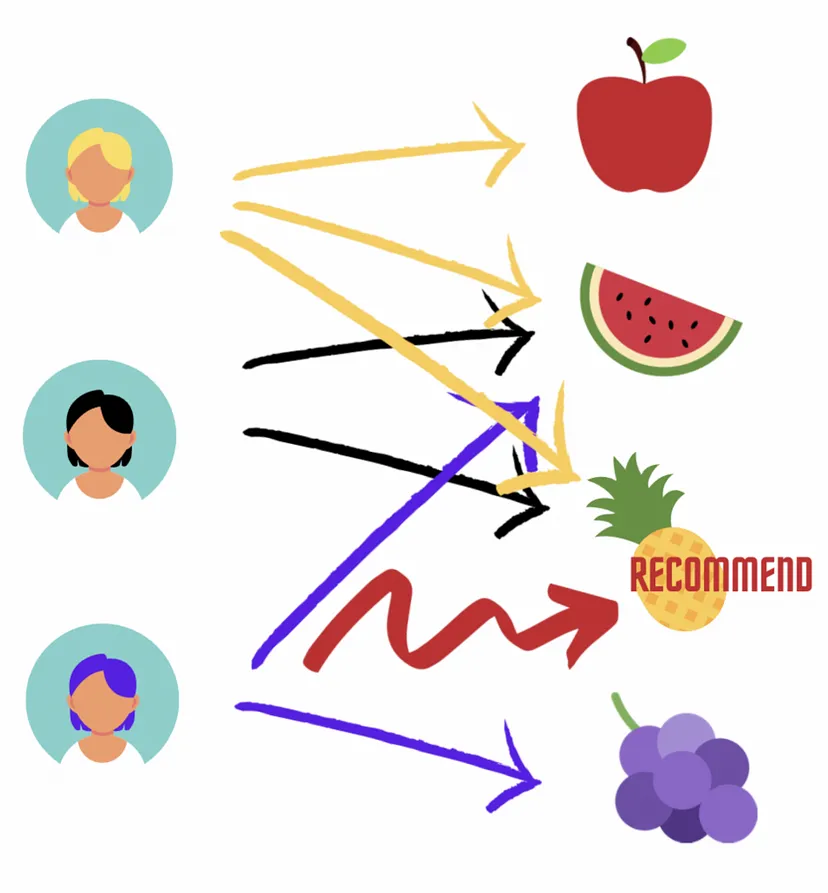

This graph illustrates how item-based collaborative filtering works using a simplified example.

Ms. Blond likes apples, watermelons, and pineapples. Ms. Black likes watermelons and pineapples. Ms. Purple likes watermelons and grapes.
Because watermelons and pineapples are liked by the sampe persons, they are considered similar items.
Since Ms. Purple likes watermelons and Ms. Purple has not been exposed to pineapples yet, the recommendation system recommends pineapples to Ms. purple.

Step 1: Import Python Libraries
In the first step, we will import Python libraries pandas, numpy, and scipy.stats. These three libraries are for data processing and calculations.

We also imported seaborn for visualization and cosine_similarity for calculating similarity scores.

In [ ]:
# Data processing
import pandas as pd
import numpy as np
import scipy.stats
# Visualization
import seaborn as sns
# Similarity
from sklearn.metrics.pairwise import cosine_similarity

Step 2: Download And Read In Data
This tutorial uses the movielens dataset. This dataset contains actual user ratings of movies.

In step 2, we will follow the steps below to get the datasets:

Go to https://grouplens.org/datasets/movielens/
Download the 100k dataset with the file name “ml-latest-small.zip”
Unzip “ml-latest-small.zip”
Copy the “ml-latest-small” folder to your project folder
Those who are using Google Colab for this analysis need to mount Google Drive to read the dataset. You can ignore the code below if you are not using Google Colab.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Change directory
import os
os.chdir("/content/drive/MyDrive/recommendation_system")
# Print out the current directory
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/recommendation_system


There are multiple datasets in the 100k movielens folder. For this tutorial, we will use two ratings and movies.

Now let’s read in the rating data.

In [ ]:
# Read in data
ratings=pd.read_csv('ml-latest-small/ratings.csv')
# Take a look at the data
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


There are four columns in the ratings dataset, userID, movieID, rating, and timestamp.

In [ ]:
# Get the dataset information
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


The dataset has over 100k records, and there is no missing data.

The 100k ratings are from 610 users on 9724 movies. The rating has ten unique values from 0.5 to 5.

In [ ]:
# Number of users
print('The ratings dataset has', ratings['userId'].nunique(), 'unique users')
# Number of movies
print('The ratings dataset has', ratings['movieId'].nunique(), 'unique movies')
# Number of ratings
print('The ratings dataset has', ratings['rating'].nunique(), 'unique ratings')
# List of unique ratings
print('The unique ratings are', sorted(ratings['rating'].unique()))


The ratings dataset has 610 unique users
The ratings dataset has 9724 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


Next, let’s read in the movies data to get the movie names.

The movies dataset has movieID, title, and genres.

In [ ]:
# Read in data
movies = pd.read_csv('ml-latest-small/movies.csv')
# Take a look at the data
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Using movieID as the matching key, we appended movie information to the rating dataset and named it df. So now we have the movie title and movie rating in the same dataset!

In [ ]:
# Merge ratings and movies datasets
df = pd.merge(ratings, movies, on='movieId', how='inner')
# Take a look at the data
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


Step 3: Exploratory Data Analysis (EDA)
In step 3, we need to filter the movies and keep only those with over 100 ratings for the analysis. This is to make the calculation manageable by the Google Colab memory.

To do that, we first group the movies by title, count the number of ratings, and keep only the movies with greater than 100 ratings.

The average ratings for the movies are calculated as well.

From the .info() output, we can see that there are 134 movies left.

In [ ]:
# Aggregate by movie
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()
# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]
# Check the information of the dataframe
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 74 to 9615
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              134 non-null    object 
 1   mean_rating        134 non-null    float64
 2   number_of_ratings  134 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ KB


Let’s check what the most popular movies and their ratings are.

In [ ]:
# Check popular movies
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,title,mean_rating,number_of_ratings
3158,Forrest Gump (1994),4.164134,329
7593,"Shawshank Redemption, The (1994)",4.429022,317
6865,Pulp Fiction (1994),4.197068,307
7680,"Silence of the Lambs, The (1991)",4.161290,279
5512,"Matrix, The (1999)",4.192446,278


Next, let’s use a jointplot to check the correlation between the average rating and the number of ratings.

We can see an upward trend from the scatter plot, showing that popular movies get higher ratings.

The average rating distribution shows that most movies in the dataset have an average rating of around 4.

The number of rating distribution shows that most movies have less than 150 ratings.

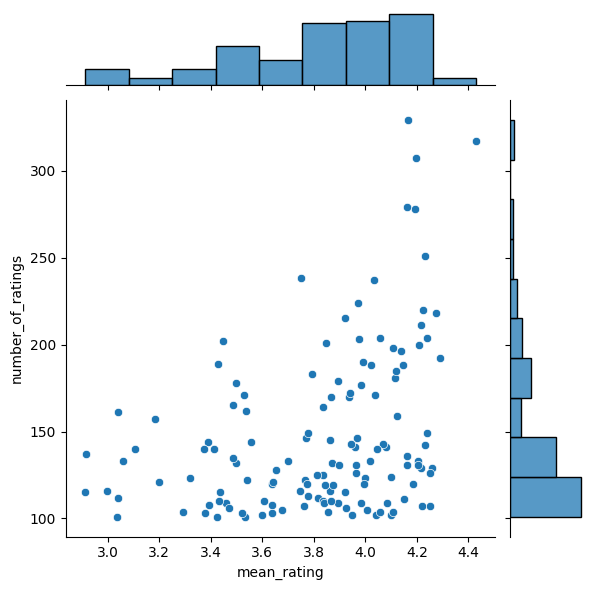

In [ ]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

To keep only the 134 movies with more than 100 ratings, we need to join the movie with the user-rating level dataframe.

how='inner' and on='title' ensure that only the movies with more than 100 ratings are included.

In [ ]:
# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19788 entries, 0 to 19787
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     19788 non-null  int64  
 1   movieId    19788 non-null  int64  
 2   rating     19788 non-null  float64
 3   timestamp  19788 non-null  int64  
 4   title      19788 non-null  object 
 5   genres     19788 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.1+ MB


After filtering the movies with over 100 ratings, we have 597 users that rated 134 movies.

In [ ]:
# Number of users
print('The ratings dataset has', df_GT100['userId'].nunique(), 'unique users')
# Number of movies
print('The ratings dataset has', df_GT100['movieId'].nunique(), 'unique movies')
# Number of ratings
print('The ratings dataset has', df_GT100['rating'].nunique(), 'unique ratings')
# List of unique ratings
print('The unique ratings are', sorted(df_GT100['rating'].unique()))

The ratings dataset has 597 unique users
The ratings dataset has 134 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


Step 4: Create User-Movie Matrix
In step 4, we will transform the dataset into a matrix format. The rows of the matrix are movies, and the columns of the matrix are users. The value of the matrix is the user rating of the movie if there is a rating. Otherwise, it shows ‘NaN’.

In [ ]:
# Create user-item matrix
matrix = df_GT100.pivot_table(index='title', columns='userId', values='rating')
matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,5.0,NaN,3.0,NaN,4.5
Ace Ventura: Pet Detective (1994),NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,2.0,NaN,NaN,NaN,3.5,NaN,3.0
Aladdin (1992),NaN,NaN,NaN,4.0,4.0,5.0,3.0,NaN,NaN,4.0,...,NaN,NaN,NaN,3.0,3.5,NaN,NaN,3.0,NaN,NaN
Alien (1979),4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,4.0,3.0,4.0,NaN,4.5
Aliens (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,3.5,NaN,4.5,NaN,5.0


Step 5: Data Normalization
In Step 5, we will normalize the data by subtracting the average rating of each movie. The cosine similarity calculated based on the normalized data is called mean-centered cosine similarity.

After normalization, the ratings less than the movie’s average rating get a negative value, and the ratings more than the movie’s average rating get a positive value.

In [ ]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 0)
matrix_norm.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),NaN,NaN,NaN,NaN,NaN,NaN,0.105505,NaN,NaN,NaN,...,NaN,NaN,1.105505,NaN,NaN,1.105505,NaN,-0.894495,NaN,0.605505
Ace Ventura: Pet Detective (1994),NaN,NaN,NaN,NaN,-0.040373,-0.040373,NaN,NaN,NaN,NaN,...,NaN,-1.040373,NaN,-1.040373,NaN,NaN,NaN,0.459627,NaN,-0.040373
Aladdin (1992),NaN,NaN,NaN,0.20765,0.207650,1.207650,-0.792350,NaN,NaN,0.20765,...,NaN,NaN,NaN,-0.792350,-0.29235,NaN,NaN,-0.792350,NaN,NaN
Alien (1979),0.030822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.030822,NaN,NaN,0.030822,-0.969178,0.030822,NaN,0.530822
Aliens (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.035714,NaN,NaN,-0.464286,NaN,0.535714,NaN,1.035714


Step 6: Calculate Similarity Score
There are different ways to measure similarities. Pearson correlation and cosine similarity are two widely used methods.

In this tutorial, we will calculate the item similarity matrix using Pearson correlation.

In [ ]:
# Item similarity matrix using Pearson correlation
item_similarity = matrix_norm.T.corr()
item_similarity.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,True Lies (1994),"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),1.000000,-0.036319,0.017446,0.318523,0.317386,0.324150,0.193592,0.152405,0.011490,0.478877,...,-0.108291,-0.012451,-0.041791,-0.458642,0.152271,0.245279,0.100172,-0.447306,0.087803,-0.123862
Ace Ventura: Pet Detective (1994),-0.036319,1.000000,0.302193,-0.208017,-0.107524,-0.030425,0.040435,0.065549,0.173855,0.245829,...,0.139896,0.188089,0.054408,0.176930,-0.007853,-0.061520,0.170717,0.176155,0.051239,0.045676
Aladdin (1992),0.017446,0.302193,1.000000,0.026514,0.151152,0.445204,0.127764,0.262014,0.367076,0.015038,...,0.333687,0.562311,-0.069176,0.137215,0.171330,0.153934,0.272375,0.065342,0.164459,0.285480
Alien (1979),0.318523,-0.208017,0.026514,1.000000,0.705925,0.387215,0.215751,0.035373,-0.006804,0.378709,...,0.199538,0.178620,0.108327,0.022007,-0.098813,0.350428,0.270697,0.119849,0.117749,0.030257
Aliens (1986),0.317386,-0.107524,0.151152,0.705925,1.000000,0.540458,0.111452,0.139326,0.076674,0.221920,...,0.369971,0.287243,0.084792,0.092412,0.195581,0.296933,0.294852,-0.014274,0.111864,0.225923


Those who are interested in using cosine similarity can refer to this code. Since cosine_similarity does not take missing values, we need to impute the missing values with 0s before the calculation.

# Item similarity matrix using cosine similarity
item_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
item_similarity_cosine

Step 7: Predict User’s Rating For One Movie
In step 7, we will predict a user’s rating for one movie. Let’s use user 1 and the movie American Pie as an example.

The prediction follows the process below:

Create a list of the movies that user 1 has watched and rated.
Rank the similarities between the movies user 1 rated and American Pie.
Select top n movies with highest similarity scores.
Calculate the predicted rating using weighted average of similarity scores and the ratings from user 1.
Now let’s implement the process using Python.

Firstly, we removed all the movies that have a missing rating for user 1, and sorted the movies by the ratings.

In [ ]:
# Pick a user ID
picked_userid = 1
# Pick a movie
picked_movie = 'American Pie (1999)'
# Movies that the target user has watched
picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                          .sort_values(ascending=False))\
                          .reset_index()\
                          .rename(columns={1:'rating'})
picked_userid_watched.head()

,title,rating
0,Dumb & Dumber (Dumb and Dumber) (1994),1.939850
1,Indiana Jones and the Temple of Doom (1984),1.361111
2,X-Men (2000),1.300752
3,E.T. the Extra-Terrestrial (1982),1.233607
4,Ghostbusters (a.k.a. Ghost Busters) (1984),1.225000


We can see that user 1’s favorite movie is Dumb and Dumber, followed by Indiana Jones and the Temple of Doom.

Next, we get the similarity score of the movie American Pie with the movie user 1 has watched, and pick the top 5 movies with the highest similarity score.

In [ ]:
# Similarity score of the movie American Pie with all the other movies
picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(columns={'American Pie (1999)':'similarity_score'})
# Rank the similarities between the movies user 1 rated and American Pie.
n = 5
picked_userid_watched_similarity = pd.merge(left=picked_userid_watched,
                                            right=picked_movie_similarity_score,
                                            on='title',
                                            how='inner')\
                                     .sort_values('similarity_score', ascending=False)[:5]
# Take a look at the User 1 watched movies with highest similarity
picked_userid_watched_similarity

,title,rating,similarity_score
52,Mission: Impossible (1996),-0.537037,0.510888
47,Twister (1996),-0.321138,0.476518
16,Star Wars: Episode I - The Phantom Menace (1999),0.892857,0.443614
10,"Fugitive, The (1993)",1.007895,0.442128
19,"Green Mile, The (1999)",0.851351,0.429560


After that, calculate the weighted average of ratings and similarities scores, so the movies with higher similarity scores get more weight. This weighted average is the predicted rating for American Pie by user 1.

In [ ]:
# Calculate the predicted rating using weighted average of similarity scores and the ratings from user 1
predicted_rating = round(np.average(picked_userid_watched_similarity['rating'],
                                    weights=picked_userid_watched_similarity['similarity_score']), 6)
print(f'The predicted rating for {picked_movie} by user {picked_userid} is {predicted_rating}' )


The predicted rating for American Pie (1999) by user 1 is 0.338739


Step 8: Movie Recommendation
In step 8, we will create an item-item movie recommendation system following four steps:

Create a list of movie that the target user has not watched before.
Loop through the unwatched movie and create predicted scores for each movie.
Rank the predicted score of unwatched movie from high to low.
Select the top k movies as the recommendations for the target user.
The Python function below implemented the four steps. With the input of picked_userid, number_of_similar_items, and number_of_recommendations, we can get the top movies for the user and their corresponding ratings. Note that the ratings are normalized by extracting the average rating for the movie, so we need to add the average value back to the predicted ratings if we want the predicted ratings to be on the same scale as the original ratings.

In [ ]:
# Item-based recommendation function
def item_based_rec(picked_userid=1, number_of_similar_items=5, number_of_recommendations =3):
  import operator
  # Movies that the target user has not watched
  picked_userid_unwatched = pd.DataFrame(matrix_norm[picked_userid].isna()).reset_index()
  picked_userid_unwatched = picked_userid_unwatched[picked_userid_unwatched[1]==True]['title'].values.tolist()
  # Movies that the target user has watched
  picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                            .sort_values(ascending=False))\
                            .reset_index()\
                            .rename(columns={1:'rating'})

  # Dictionary to save the unwatched movie and predicted rating pair
  rating_prediction ={}
  # Loop through unwatched movies
  for picked_movie in picked_userid_unwatched:
    # Calculate the similarity score of the picked movie iwth other movies
    picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(columns={picked_movie:'similarity_score'})
    # Rank the similarities between the picked user watched movie and the picked unwatched movie.
    picked_userid_watched_similarity = pd.merge(left=picked_userid_watched,
                                                right=picked_movie_similarity_score,
                                                on='title',
                                                how='inner')\
                                        .sort_values('similarity_score', ascending=False)[:number_of_similar_items]
    # Calculate the predicted rating using weighted average of similarity scores and the ratings from user 1
    predicted_rating = round(np.average(picked_userid_watched_similarity['rating'],
                                        weights=picked_userid_watched_similarity['similarity_score']), 6)
    # Save the predicted rating in the dictionary
    rating_prediction[picked_movie] = predicted_rating
    # Return the top recommended movies
  return sorted(rating_prediction.items(), key=operator.itemgetter(1), reverse=True)[:number_of_recommendations]
# Get recommendations
recommended_movie = item_based_rec(picked_userid=1, number_of_similar_items=5, number_of_recommendations =3)
recommended_movie

[('Austin Powers: The Spy Who Shagged Me (1999)', 1.096288),
 ('Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)', 0.92924),
 ('Lord of the Rings: The Return of the King, The (2003)', 0.926824)]